In [1]:
%load_ext autoreload
%autoreload 2

# Linear regression with laplace prior
 + In general, laplace prior gives sparse result for regression
     + However, it is difficult to deal with it well due to non-differential point at the origin.
         + $\log p(w) \equiv -1/\beta \sum_j |w_j| $, $|w_j|$ is non-differential at the origin.
 + By the way, non-differential point is eliminated by integrating $|w_j|$:
     + $E[|w_j|]$ does not have non-diffenrential point when the distribution is normal distribution.
     + It is achieved when we consider about the objective function of variational Bayes.
         + $\mathcal{F} := E[\log \frac{q(w)}{p(Y|X,w}p(w)]$
         + Here, $\mathcal{F}$ has a parameter that decides the form of $q(w) = N(w|m, \Sigma)$, $(m, \Sigma)$ is the parameter and optimized by it.
 + In this notebook, the approximated posterior distribution by Variational Bayes is studied.
     + The objective function is optimized by a gradient descent method.
         + Specifically, the Natural gradient descent is efficient method when we consider about a constrained parameter like positive definite matrix, positive real value, simplex, and so on.
         + Thus, we used the natural gradient descent.

# Formulation
+ Learning Model:
    + $p(y|x,w) = N(y|x \cdot w, 1), y \in mathbb{R}, x,w \in \mathbb{R}^M$
    + $p(w) \equiv \exp(-\frac{1}{\beta} \sum_j |w_j|)$, $\beta$ is hyperparameter.
+ Approximated Variational Posterior distribution:
    + $q(w) = N(w|m, \Sigma)$
        + $m \in \mathbb{R}^M, \Sigma \in \mathbb{R}^{M \times M}$ is the parameters to be optimized.

# In this notebook
+ We compare the following average generalization error:
$$
    G(n) = \frac{1}{L} \sum_{j=1}^L \| y - X \hat{w}(x^l, y^l) \|^2,
$$
where $\hat{w}$ is estimated parameter by $(x^l, y^l)$.  
We evaluate the error among Lasso, Ridge, and VB laplace(this calculation).

# Preliminary
## Import library

In [2]:
import numpy as np
from scipy.stats import norm
from scipy.stats import invwishart

In [3]:
from sklearn.linear_model import LassoCV, Lasso, LassoLarsCV
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.base import BaseEstimator, RegressorMixin

## Data setting

In [4]:
## data setting
n = 500 # train size
M = 1500 # # of features
n_zero_ind = M // 4 * 3 # # of zero elements in the parameter
prob_seed = 20201110 # random seed

N = 10000 # test size

datasets = 100

## Problem setting

In [5]:
np.random.seed(prob_seed)
true_w = np.random.normal(scale = 3, size = M)
zero_ind = np.random.choice(M, size = n_zero_ind)
true_w[zero_ind] = 0

## Learning settings

In [6]:
ln_vb_params = {
    "pri_beta": 10,
    "pri_opt_flag": True,
    "iteration": 10000,
    "step": 0.2,
    "is_trace": False,
    "trace_step": 100
}
ln_lasso_params = {
    "fit_intercept": False,
    "cv": 5,
    "max_iter": 10000
}
ln_ridge_params = {
    "fit_intercept": False,
    "cv": 5
}

## Classes

In [7]:
class VBLaplace(BaseEstimator, RegressorMixin):
    def __init__(
        self, pri_beta: float = 20, pri_opt_flag: bool = True,
        seed: int = -1, iteration: int = 1000, tol: float = 1e-8, step: float = 0.1,
        is_trace: bool = False, trace_step: int = 20
    ):
        self.pri_beta = pri_beta
        self.pri_opt_flag = pri_opt_flag
        self.seed = seed
        self.iteration = iteration
        self.tol = tol
        self.step = step
        self.is_trace = is_trace
        self.trace_step = trace_step
        pass
    
    def _initialization(self, M: int):
        seed = self.seed
        
        if seed > 0:
            np.random.seed(seed)
        
        mean = np.random.normal(size = M)
        sigma = invwishart.rvs(df = M+2, scale = np.eye(M), size = 1)
        pri_beta = np.random.gamma(shape = 3, size = 1) if self.pri_opt_flag else self.pri_beta
        
        self.mean_ = mean
        self.sigma_ = sigma
        self.pri_beta_ = pri_beta
        pass
    
    def _obj_func(self, X:np.ndarray, y:np.ndarray, pri_beta:float, mean:np.ndarray, sigma:np.ndarray) -> float:
        """
        Calculate objective function.

        + Input:
            1. X: input matrix (n, M) matrix
            2. y: output vector (n, ) matrix
            3. mean: mean parameter of vb posterior
            4. sigma: covariance matrix of vb posterior

        + Output:
            value of the objective function.

        """

        n, M = X.shape

        sq_sigma_diag = np.sqrt(np.diag(sigma))
        log_2pi = np.log(2*np.pi)

        F = 0
        # const values
        F += -M/2*log_2pi -M/2 + M*log_2pi + n*M/2*log_2pi + M*np.log(2*pri_beta)

        F += ((y - X@mean)**2).sum()/2 - np.linalg.slogdet(sigma)[1]/2 + np.trace(X.T @ X @ sigma)/2

        # term obtained from laplace prior
        F += ((mean + 2*sq_sigma_diag*norm.pdf(-mean/sq_sigma_diag)-2*mean*norm.cdf(-mean/sq_sigma_diag))/pri_beta).sum()

        return F
    
    def fit(self, train_X:np.ndarray, train_Y:np.ndarray):
        pri_beta = self.pri_beta
        iteration = self.iteration
        step = self.step
        tol = self.tol
        
        is_trace = self.is_trace
        trace_step = self.trace_step
        
        M = train_X.shape[1]
        
        if not hasattr(self, "mean_"):
            self._initialization(M)
        
        est_mean = self.mean_
        est_sigma = self.sigma_
        est_pri_beta = self.pri_beta_
        
        # transformation to natural parameter
        theta1 = np.linalg.solve(est_sigma, est_mean)
        theta2 = -np.linalg.inv(est_sigma)/2        
        
        F = []
        
        cov_X = train_X.T @ train_X
        cov_YX = train_Y @ train_X
        for ite in range(iteration):
            sq_sigma_diag = np.sqrt(np.diag(est_sigma))

            # update mean and sigma by natural gradient
            dFdnu1 = theta1 - cov_YX
            dFdnu1 += (1 - 2*est_mean/sq_sigma_diag*norm.pdf(-est_mean/sq_sigma_diag) - 2*norm.cdf(-est_mean/sq_sigma_diag)) / est_pri_beta
            dFdnu2 = theta2 + cov_X/2
            dFdnu2[np.diag_indices(M)] += 1/sq_sigma_diag*norm.pdf(-est_mean/sq_sigma_diag)/est_pri_beta

            theta1 += -step * dFdnu1
            theta2 += -step * dFdnu2
            est_sigma = -np.linalg.inv(theta2)/2
            est_mean = est_sigma @ theta1
            
            # update pri_beta by extreme value
            sq_sigma_diag = np.sqrt(np.diag(est_sigma))
            est_pri_beta = ((est_mean + 2*sq_sigma_diag*norm.pdf(-est_mean/sq_sigma_diag)-2*est_mean*norm.cdf(-est_mean/sq_sigma_diag))).mean() if self.pri_opt_flag else pri_beta
            current_F = self._obj_func(train_X, train_Y, est_pri_beta, est_mean, est_sigma)
            if is_trace and ite % trace_step == 0:
                print(current_F, (dFdnu1**2).sum(), (dFdnu2**2).sum())            
            
            if ite > 0 and np.abs(current_F - F[ite-1]) < tol:
                if is_trace:
                    print(current_F, (dFdnu1**2).sum(), (dFdnu2**2).sum())                            
                break
            else:
                F.append(current_F)
            pass
        
        
        self.F_ = F
        self.mean_ = est_mean
        self.sigma_ = est_sigma
        self.pri_beta_ = est_pri_beta
        
        return self
        pass
    
    def predict(self, test_X: np.ndarray):
        if not hasattr(self, "mean_"):
            raise ValueError("fit has not finished yet, should fit before predict.")
        return test_X @ self.mean_
        pass
        
    pass

In [8]:
class VBNormal(BaseEstimator, RegressorMixin):
    def __init__(
        self, pri_beta: float = 20, pri_opt_flag: bool = True,
        seed: int = -1, iteration: int = 1000, tol: float = 1e-8, step: float = 0.1,
        is_trace: bool = False, trace_step: int = 20
    ):
        self.pri_beta = pri_beta
        self.pri_opt_flag = pri_opt_flag
        self.seed = seed
        self.iteration = iteration
        self.tol = tol
        self.step = step
        self.is_trace = is_trace
        self.trace_step = trace_step
        pass
    
    def _initialization(self, M: int):
        seed = self.seed
        
        if seed > 0:
            np.random.seed(seed)
        
        mean = np.random.normal(size = M)
        sigma = invwishart.rvs(df = M+2, scale = np.eye(M), size = 1)
        pri_beta = np.random.gamma(shape = 3, size = 1) if self.pri_opt_flag else self.pri_beta
        
        self.mean_ = mean
        self.sigma_ = sigma
        self.pri_beta_ = pri_beta
        pass
    
    def _obj_func(self, X:np.ndarray, y:np.ndarray, pri_beta:float, mean:np.ndarray, sigma:np.ndarray) -> float:
        """
        Calculate objective function.

        + Input:
            1. X: input matrix (n, M) matrix
            2. y: output vector (n, ) matrix
            3. mean: mean parameter of vb posterior
            4. sigma: covariance matrix of vb posterior

        + Output:
            value of the objective function.

        """

        n, M = X.shape

        log_2pi = np.log(2*np.pi)

        F = 0
        # const values
        F += -M/2*log_2pi -M/2 + M*log_2pi + n*M/2*log_2pi + M*np.log(2*pri_beta)

        F += ((y - X@mean)**2).sum()/2 - np.linalg.slogdet(sigma)[1]/2 + np.trace(X.T @ X @ sigma)/2

        # term obtained from Normal prior
        F += pri_beta/2*(mean@mean + np.trace(sigma)) - M/2*np.log(pri_beta) + M/2*log_2pi
        
        return F
    
    def fit(self, train_X:np.ndarray, train_Y:np.ndarray):
        pri_beta = self.pri_beta
        iteration = self.iteration
        step = self.step
        tol = self.tol
        
        is_trace = self.is_trace
        trace_step = self.trace_step
        
        M = train_X.shape[1]
        
        if not hasattr(self, "mean_"):
            self._initialization(M)
        
        est_mean = self.mean_
        est_sigma = self.sigma_
        est_pri_beta = self.pri_beta_
                
        F = []
        XY_cov = train_Y@train_X
        X_cov = train_X.T@train_X
        
        for ite in range(iteration):
            sigma_inv = X_cov + est_pri_beta*np.eye(M)
            est_mean = np.linalg.solve(sigma_inv, XY_cov)
            est_sigma = np.linalg.inv(sigma_inv)
            
            # update pri_beta by extreme value
            est_pri_beta = M/(est_mean@est_mean + np.trace(est_sigma)) if self.pri_opt_flag else pri_beta
            current_F = self._obj_func(train_X, train_Y, est_pri_beta, est_mean, est_sigma)
            if is_trace and ite % trace_step == 0:
                print(current_F, (dFdnu1**2).sum(), (dFdnu2**2).sum())            
            
            if ite > 0 and np.abs(current_F - F[ite-1]) < tol:
                if is_trace:
                    print(current_F, (dFdnu1**2).sum(), (dFdnu2**2).sum())                            
                break
            else:
                F.append(current_F)
            pass
        
        
        self.F_ = F
        self.mean_ = est_mean
        self.sigma_ = est_sigma
        self.pri_beta_ = est_pri_beta
        
        return self
        pass
    
    def predict(self, test_X: np.ndarray):
        if not hasattr(self, "mean_"):
            raise ValueError("fit has not finished yet, should fit before predict.")
        return test_X @ self.mean_
        pass
        
    pass

In [9]:
class VBApproxLaplace(BaseEstimator, RegressorMixin):
    """
    Laplace prior is approximated by normal distribution, and approximated posterior distribution is obtained by the approximated laplace prior.
    """
    
    def __init__(
        self, pri_beta: float = 20, pri_opt_flag: bool = True,
        seed: int = -1, iteration: int = 1000, tol: float = 1e-8, step: float = 0.1,
        is_trace: bool = False, trace_step: int = 20
    ):
        self.pri_beta = pri_beta
        self.pri_opt_flag = pri_opt_flag
        self.seed = seed
        self.iteration = iteration
        self.tol = tol
        self.step = step
        self.is_trace = is_trace
        self.trace_step = trace_step
        pass
    
    def _initialization(self, M: int):
        seed = self.seed
        
        if seed > 0:
            np.random.seed(seed)
        
        mean = np.random.normal(size = M)
        sigma = invwishart.rvs(df = M+2, scale = np.eye(M), size = 1)
        pri_beta = np.random.gamma(shape = 3, size = 1) if self.pri_opt_flag else self.pri_beta
        
        self.mean_ = mean
        self.sigma_ = sigma
        self.pri_beta_ = pri_beta
        pass
    
    def _obj_func(self, y:np.ndarray, pri_beta:float, mean:np.ndarray, inv_sigma:np.ndarray, h_xi: np.ndarray, v_xi: np.ndarray) -> float:
        """
        Calculate objective function.

        + Input:
            1. X: input matrix (n, M) matrix
            2. y: output vector (n, ) matrix
            3. mean: mean parameter of vb posterior
            4. sigma: covariance matrix of vb posterior

        + Output:
            value of the objective function.

        """

        F = 0
        F += pri_beta/2*np.sqrt(h_xi).sum() + v_xi@h_xi - M*np.log(pri_beta/2)
        F += n/2*np.log(2*np.pi) + train_Y@train_Y/2 - mean @ (inv_sigma @ mean)/2 + np.linalg.slogdet(inv_sigma)[0]/2
        return F
    
    def fit(self, train_X:np.ndarray, train_Y:np.ndarray):
        iteration = self.iteration
        step = self.step
        tol = self.tol
        
        is_trace = self.is_trace
        trace_step = self.trace_step
        
        M = train_X.shape[1]
        
        if not hasattr(self, "mean_"):
            self._initialization(M)
        
        est_mean = self.mean_
        est_sigma = self.sigma_
        est_pri_beta = self.pri_beta_
                
        F = []
        X_cov = train_X.T@train_X
        XY_cov = train_X.T @ train_Y
        
        for ite in range(iteration):
            # update form of approximated laplace prior
            est_h_xi = est_mean**2 + np.diag(est_sigma)
            est_v_xi = -est_pri_beta/2/np.sqrt(est_h_xi)            
            
            # update posterior distribution
            inv_sigma = X_cov -2*np.diag(est_v_xi)
            est_mean = np.linalg.solve(inv_sigma, XY_cov)
            est_sigma = np.linalg.inv(inv_sigma)
            
            # update pri_beta by extreme value
            est_pri_beta = M/((est_mean**2 + np.diag(est_sigma))/(2*np.sqrt(est_h_xi))).sum() if self.pri_opt_flag else pri_beta
            
            current_F = self._obj_func(train_Y, est_pri_beta, est_mean, inv_sigma, est_h_xi, est_v_xi)
            if is_trace and ite % trace_step == 0:
                print(current_F)            
            
            if ite > 0 and np.abs(current_F - F[ite-1]) < tol:
                if is_trace:
                    print(current_F, (dFdnu1**2).sum(), (dFdnu2**2).sum())                            
                break
            else:
                F.append(current_F)
            pass
        
        
        self.F_ = F
        self.mean_ = est_mean
        self.sigma_ = est_sigma
        self.pri_beta_ = est_pri_beta
        
        return self
        pass
    
    def predict(self, test_X: np.ndarray):
        if not hasattr(self, "mean_"):
            raise ValueError("fit has not finished yet, should fit before predict.")
        return test_X @ self.mean_
        pass    
    pass

# Experiment part
+ By some datasets are used for train and evaluate

In [10]:
sq_error_vb_laplace_exact = np.zeros(datasets)
sq_error_vb_laplace_approx = np.zeros(datasets)
sq_error_vb_normal = np.zeros(datasets)
sq_error_lasso = np.zeros(datasets)
sq_error_ridge = np.zeros(datasets)

for dataset_ind in range(datasets):
    vb_laplace_exact_obj = VBLaplace(**ln_vb_params)
    vb_laplace_approx_obj = VBApproxLaplace(**ln_vb_params)
    vb_normal_obj = VBNormal(**ln_vb_params)
    lasso_obj = LassoCV(**ln_lasso_params)
    ridge_obj = RidgeCV(**ln_ridge_params)    
    
    # data generation
    train_X = np.random.normal(size = (n, M))
    train_Y = train_X @ true_w + np.random.normal(size = n)

    lasso_obj.fit(train_X, train_Y)
    ridge_obj.fit(train_X, train_Y)
    vb_laplace_exact_obj.fit(train_X, train_Y)
    vb_normal_obj.fit(train_X, train_Y)
    vb_laplace_approx_obj.fit(train_X, train_Y)

    test_X = np.random.normal(size = (N, M))
    test_Y = test_X @ true_w + np.random.normal(size = N)
    
    sq_error_lasso[dataset_ind] = ((test_X @ lasso_obj.coef_- test_Y)**2).mean()
    sq_error_ridge[dataset_ind] = ((test_X @ ridge_obj.coef_- test_Y)**2).mean()
    sq_error_vb_laplace_exact[dataset_ind] = ((test_X @ vb_laplace_exact_obj.mean_- test_Y)**2).mean()
    sq_error_vb_normal[dataset_ind] = ((test_X @ vb_normal_obj.mean_- test_Y)**2).mean()
    sq_error_vb_laplace_approx[dataset_ind] = ((test_X @ vb_laplace_approx_obj.mean_- test_Y)**2).mean()
    print(
        sq_error_lasso[dataset_ind]
        , sq_error_ridge[dataset_ind]
        , sq_error_vb_laplace_exact[dataset_ind]
        , sq_error_vb_normal[dataset_ind]
        , sq_error_vb_laplace_approx[dataset_ind]
    )

4534.311991090998 4075.4814729137124 3787.090488049996 4074.831615744289 3934.9607198985964
4429.190577525714 4208.1193711598025 3877.4592353126077 4207.194872348408 3935.0493056406217
4517.152756175873 4144.5486834821195 3934.146850665892 4144.537917473443 4219.516742241699
4832.417303789781 4154.091435690235 3997.6419846491563 4153.613699463033 4366.391836895246
4899.6158574441015 4271.145227399941 3982.9267684898778 4271.1645378255 4104.851411020691
5007.036005383226 3973.1684514652943 3644.9990883110167 3973.1707369413034 3728.9777932541965
4981.97269253664 4155.333299982712 3891.445968329353 4155.336785196968 4160.550615059665
4824.814616604173 3964.24440632008 3762.213201241725 3964.255862901935 4054.6980074114867
4325.753160403825 4008.605895650634 3708.1456453838423 4008.6179438365943 3879.746389472306
4618.668067112397 4222.7786682684855 3956.831147049704 4223.208361716816 4157.194125204899
4583.316768012168 3998.785625885353 3748.1863336151005 3999.4065060550047 3910.60460045

KeyboardInterrupt: 

In [11]:
print(
    sq_error_lasso.mean()
    , sq_error_ridge.mean()
    , sq_error_vb_laplace_exact.mean()
    , sq_error_vb_normal.mean()
    , sq_error_vb_laplace_approx.mean()
)

1597.5805015494159 1399.8496880104549 1312.4747040190964 1399.8460264636356 1376.1151546052888


In [39]:
import matplotlib.pyplot as plt

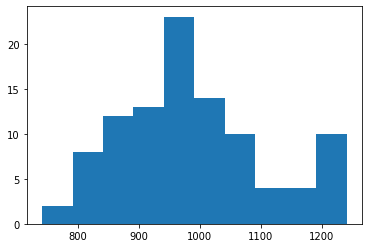

In [41]:
plt.hist(sq_error_lasso)
plt.show()

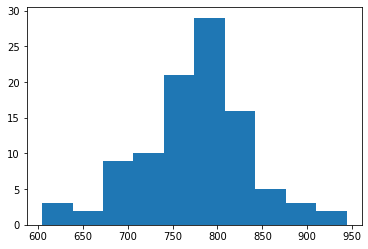

In [42]:
plt.hist(sq_error_vb_laplace_exact)
plt.show()

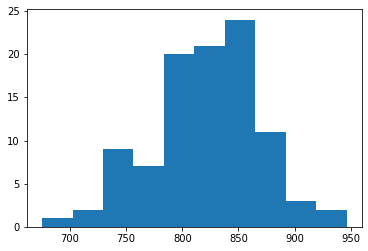

In [43]:
plt.hist(sq_error_vb_normal)
plt.show()

In [23]:
sq_error_lasso.std()

65.10485992387093

In [20]:
true_w

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.76668197,
        0.07758316,  0.        , -0.0995576 ,  0.        , -0.90644613,
        0.        ,  0.        , -1.16645995,  1.00565264, -1.27819984,
        0.30094245, -0.627204  ,  3.38047157,  1.22344481,  0.0473449 ,
       -0.03814966,  0.        ,  0.        ,  3.52029545,  0.        ,
        4.81596502,  0.        , -3.25347577,  0.66002526,  0.        ,
        0.        ,  0.        ,  0.        ,  2.63380714,  1.33677451,
        0.        , -2.69622796,  3.58475763,  0.        ,  0.        ,
        2.71306942,  0.        ,  1.88162727, -2.59235379,  3.48865255,
        0.        ,  0.        ,  0.        ,  2.00792993, -0.4410573 ,
        0.        , -4.15620415,  3.9016001 ,  0.        ,  6.5176337 ,
       -3.96303101, -0.03691128,  1.35713552,  2.36783035,  0.        ,
        0.        ,  0.18762913, -1.26910508, -3.83069906,  0.26426108,
       -1.0842188 ,  0.        ,  0.        ,  0.        ,  0.  